# ZMS LAB 043 - case GWINTEX

kontakt: annaszczurek2@gmail.com


## Opis zajęć


Firma GWINTEX S.A. jest międzynarodowym potentatem w dziedzinie produkcji korkociągów. Korkociągi są wytwarzane na bardzo nowoczesnych maszynach metalurgicznych. W związku ze znacznym wzrostem zamówień firma planuje uruchomienie nowej hali produkcyjnej, w której znajdzie się **n=6 maszyn**. Do każdej maszyny jest przypisany operator, który jest odpowiedzialny za jej obsługę oraz usuwanie awarii. Na podstawie pomiarów historycznych wiadomo, że **czas bezawaryjnej pracy maszyny ma rozkład wykładniczy ze średnią 75 minut**. W przypadku wystąpienia awarii operator dzwoni do warsztatu z prośbą o dostarczenie pakietu narzędzi naprawczych. Pakiet narzędzi jest bardzo ciężki i w związku z tym musi być transportowany za pomocą przenośnika taśmowego (taśmociągu). **Czas transportu zestawu narzędzi do maszyny wynosi *ti*, i=1..6. Czas naprawy jest zmienną losową z rozkładu Erlanga k=3 i średnio wynosi 15 minut**. Po ukończeniu naprawy narzędzia są powtórnie umieszczane na taśmociągu i wracają w komplecie do warsztatu celem ich uzupełnienia. Ze względu na specyfikę specjalistycznych narzędzi nie jest możliwe dokonywanie kolejnych napraw przed powrotem narzędzi do warsztatu. Ze względu na bardzo wysoką cenę jednego pakietu narzędzi naprawczych ich liczba ***m* jest mniejsza od liczby maszyn w hali produkcyjnej**. Gdy w danej chwili pakiet narzędzi nie jest dostępny operator czeka aż inny pakiet wróci do warsztatu i zostanie mu wysłany.

Zarząd firmy GWINTEX zastanawia się **jakie powinno być rozmieszczenie urządzeń na hali produkcyjnej** oraz **ile pakietów narzędziowych do obsługi maszyn należy zakupić**. Rozważane są dwie organizacje hali produkcyjnej – układ liniowy oraz układ gniazdowy. **W układzie liniowym czas transportu narzędzi z warsztatu do maszyny wynosi ***ti=i*2***, natomiast **w układzie gniazdowym czas ten jest stały i wynosi 3 minuty**. Czas transportu narzędzi do warsztatu jest taki sam jak czas transportu do maszyny. Wprowadzenie układu gniazdowego wiąże się z wyższymi kosztami instalacyjnymi związanymi z uruchomieniem sześciu niezależnych taśmociągów.




## ROZWIĄZANIE

*author: P*

### 1. Stałe i zmienne wykorzystane w modelu

In [1]:
import numpy as np

In [2]:
# liczba maszyn
n = 6 

# średni czas pracy bez usterki
avg_working_time = 75 # minut

# średni czas naprawy
avg_repair_time = 15 # minut

# ilość zestawów narzędzi
m = 6

# horyzont analizy
horizon = 30 # dni

# liczba uruchomień symulacji
iterations = 1000   

In [3]:
# Toolset transport times for all considered setups - this should facilitate easier handling of new
# setups
transport_times = {'L': {i:2*(i+1) for i in range(6)}, 'G': {i:3 for i in range(6)},
                   'L2': {0:6, 1:4, 2:2, 3:2, 4:4, 5:6}}

### 2. Model

Wektory, które mają za zadanie kontrolować stan symulacji:

- momenty wystąpienia kolejnych zdarzeń
- status narzędzi i maszyn 
    - `W` - pracuje 
    - `Q` - czeka na narzedzia 
    - `R` - jest naprawiona
- czas ich bezczynności
- events --> wektor zdarzeń, które zmieniają stan symulacji (np. zepsucie się maszyny, czas naprawy, itp.)

In [5]:
def model(horizon, avg_working_time, avg_repair_time, n, m, setup):
    # setup - układ liniowy "L" lub gniazdowy "G"
    
    # horyzont działania w minutach
    horizon = horizon * 24 * 60 
    
    # wektor zdarzeń, który zmienia stan symulacji
    events = list(np.random.exponential(avg_working_time, n))
    
    # status - określa aktualny stan maszyny 
    status = ["W"] * n

    # t_start - określa początek bezczynności maszyny
    t_start = [0] * n

    # t_cum - skumulowany czas bezczynności maszyny
    t_cum = [0] * n

    # tools_loc lokalizacja narzedzi - albo numer maszyny albo -1 czyli warsztat
    tools_loc = [-1] * m

    # tools_occupied czas zajecia zestawu przez naprawianą maszynę
    tools_occupied = [0] * m
    
    # zegar symulacji- najblizsze zadanie, które ma być wykonane
    t = min(events)
    
    # rozpoczynamy symulacje "skacząc" po kolejnych zdarzeniach  
    while t <= horizon:
        
        # jeżeli zestawy nie są aktualnie zajęte to przenosimy je z powrotem do warsztatu
        for i in range(m):
            if tools_occupied[i] <= t:
                tools_loc[i] = -1

        # wybieramy maszynę, której dotyczy zdarzenie
        machine = events.index(t)
        
        """
        Gdy maszyna, której dotyczy zdarzenie ma status "W":
            - to najpierw zaktualizuj wektor t_start dla tej maszyny jako początek jej bezczynności = t.
            - następnie sprawdź czy dostępny jest jakiś zestaw naprawczy. Jezeli nie:
                - to ustaw status maszyny na "Q" 
                - zaktualizuj wektor events podajac mu najkrótszy czas oczekiwania na wolny zestaw.
              Jeżeli tak:
                - ustaw status maszyny na "R"
                - wyznacz czas  potrzebny na naprawę maszyny w zależności od ukladu taśmociągu 
                (czas transportu + czas naprawy)
                - ustaw koniec naprawy jako zdarzenie dla danej maszyny
                - zaktualizuj wektor tools_loc dla odpowiedniego zestawu podając numer maszyny, którą on obsługuje
                - zaktualizuj wektor tools_occupied czasem jaki mu to zajmie (2* transport + naprawa)
        """
        if status[machine] == "W":
            t_start[machine] = t
            tools = - 1
            for i in range(m):
                if tools_loc[i] == -1:
                    tools = i
                    break
            if tools == -1 :
                status[machine] = "Q"
                events[machine] = min(tools_occupied)
            else:
                status[machine] = "R"
                transport_time = transport_times[setup][machine]
                repair_time = np.random.gamma(3, avg_repair_time/3)
                events[machine] += repair_time + transport_time
                tools_loc[tools] = machine
                tools_occupied[tools] += repair_time + 2 * transport_time
                
                """
                Gdy maszyna ma status "Q":
                    - wybierz dostępny zestaw naprawczy
                    - ustal status maszyny na "R"
                    - zaktualizuj wektor tools_loc lokalizacją narzedzi i tools_occupied 
                    czasem jaki zajmie ich transport (w dwie strony) i naprawa maszyny
                    -zaktualizuj wektor zdarzeń czasem potrzebnym na naprawę maszyny i transport narzedzi
                """
                
        elif status[machine] == "Q":
            for i in range(m):
                if tools_loc[i] == -1:
                    tools = i
                    break
            status[machine] = "R"
            transport_time = transport_times[setup][machine]
            repair_time = np.random.gamma(3, avg_repair_time/3)
            events[machine] += repair_time + transport_time
            tools_loc[tools] = machine
            tools_occupied[tools] += repair_time + 2 * transport_time 
            """
            Gdy maszyna ma status "R":
                - ustal jej status na "W"
                - wyznacz czas kolejnej awarii i zaktualizuj wektor events
                - wylicz czas bezczynnosci i uzupelnij o niego liste t_cum
            """
            
        else:
            status[machine] = "W"
            events[machine] += np.random.exponential(avg_working_time)
            t_cum[machine] += t - t_start[machine]
        
        # ustalamy nowe t
        t = min(events)
        
    # wynik - liste skumulowanych bezczynnosci dla kazdej z maszyn
    return (t_cum)

### 3. Funkcja do uruchomienia symulacji

Added seed to provide reproducibility of results

In [9]:
def run_model (iterations, horizon, avg_working_time, avg_repair_time, n, m, setup):
    avg_t_cum = []
    for i in range (iterations):
        np.random.seed(i)
        avg_t_cum.append(model( horizon, avg_working_time, avg_repair_time, n, m, setup))
    return list(map(np.mean, np.transpose(avg_t_cum)))


### 3. Symulacja

In [7]:
run_model(iterations, horizon, avg_working_time, avg_repair_time, n, m, "L")

[7974.3852002945396,
 8730.3138986444428,
 9451.6315973996261,
 10128.150628311123,
 10818.61986875565,
 11450.562571701917]

In [8]:
run_model(iterations, horizon, avg_working_time, avg_repair_time, n, m, "L")

[7963.7787671263422,
 8726.912115948162,
 9451.1463341973431,
 10127.195944205723,
 10778.285911584057,
 11453.647507362011]

In [18]:
run_model(iterations, horizon, avg_working_time, avg_repair_time, n, m, "G")

[8313.5019853223403,
 8287.4807087069039,
 8525.7107725203095,
 8654.0727393056532,
 8425.2484168141636,
 8483.1339937925459]

In [21]:
run_model(iterations, horizon, avg_working_time, avg_repair_time, n, m, "L2")

[9425.0862005853669,
 8776.1980700145123,
 8018.6077757133562,
 8340.5776848787864,
 8561.0899056974868,
 9440.1565673060777]

### 4. Simplest comparison

In [10]:
import time

In [11]:
t0 = time.clock()
results = {}
for setup in ['L', 'G', 'L2']:
    for m in range(5):
        results[(setup, m+1)] = run_model(iterations, horizon, avg_working_time, avg_repair_time, n, m+1, setup)
print('Entire simulation duration time: {:.1f}s'.format(time.clock() - t0))

Entire simulation duration time: 1204.5s


In [12]:
from pandas import DataFrame

In [13]:
df = DataFrame.from_dict(results).T

In [14]:
from matplotlib import pyplot as plt

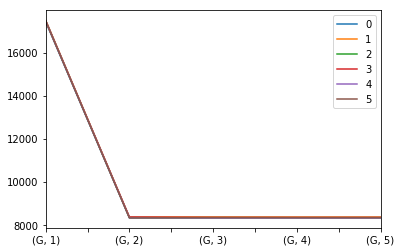

In [15]:
df.loc[('G', slice(None)),:].plot()

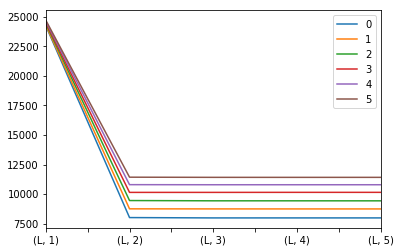

In [16]:
df.loc[('L', slice(None)),:].plot()

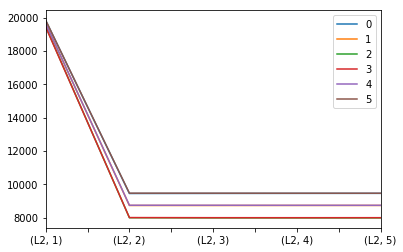

In [17]:
df.loc[('L2', slice(None)),:].plot()

Interestingly, either the simulation code contains some mistakes or buying more than 2 toolkits doesn't materially improve the efficiency.

In [19]:
df2 = df.mean(axis=1).unstack()

Basing on the table above we can approximate various intervals of machine downtime cost at which each solution would be optimal

In [20]:
df2 

,1,2,3,4,5
G,17464.526793,8360.691080,8357.604714,8357.481145,8357.481145
L,24467.989674,9770.147599,9757.190036,9757.330314,9757.089707
L2,19641.057846,8724.301445,8721.910920,8721.458366,8722.070405


In [23]:
df2.loc["L2",:] / df2.loc['L',:]

1    0.802725
2    0.892955
3    0.893896
4    0.893837
5    0.893921
dtype: float64

First observation is that for the initial parametrization, the proposed rearrangement of the linear setup provides at least 10% less machine downtime on average.

In [29]:
df2.loc[:,2:5].values / df2.loc[:,1:4].values

array([[ 0.47872417,  0.99963085,  0.99998521,  1.        ],
       [ 0.39930324,  0.99867376,  1.00001438,  0.99997534],
       [ 0.44418694,  0.99972599,  0.99994811,  1.00007018]])

The table above shows that while buying a second toolkit reduces machine downtime by more than 50%, purchasing more toolkits has almost no impact on total downtime. This will be most likely dependent on average time between failures as well as average repair time - do we want to analyse this relationship?

In [39]:
(df2.loc[:,1].values - df2.loc[:,2].values) / 60

array([ 151.73059523,  244.96403459,  181.94594001])

In [41]:
(df2.loc['L':'L2',2].values - df2.loc['G',2]) / 60

array([ 23.49094198,   6.06017276])

<b>Key findings:</b>
- In the current setting, a most-likely optimal scenario would be to purchase 2 toolkits.
- Notably, buying a second toolkit is much more important than changing the setup from linear to spherical/radial (or whatever the proper English name would be). This pays off as long as the cost of a single toolkit is no higher than 245 hours of monthly downtime per machine (181 hours if the modified linear setup can be accommodated).
- Any further improvement would require implementing radial setup instead of the linear one. This is reasonable when the extra cost of implementing this setup doesn't exceed the costs associated with an average of 23.5 hours of downtime per machine (6 if the modified linear setup is feasible).
- Thus, if machine downtime costs is moderate, the recommended solution is to implement the modified linear setup and purchase 2 toolkits. Profits from any further investments will be negligible, unless the cost difference between the spherical and the linear setup is also small.</li>
<br><b>TBA: sensitivity analysis (suggested variables: average time between failures, average repair time, perhaps variance of the repair time)</b>

<b>Issues:</b>
- Since df2.loc['G',4] == df2.loc['G',5] should we be worried about proper seed setting?

<b>Data export</b><br>
<i>So that it is not necessary to run the simulation over and over again to modify a few plots</i>

In [43]:
df.to_hdf('results.hdf', key = 'full_results')
df2.to_hdf('results.hdf', key = 'machine_means')

In [45]:
# Check
from pandas import read_hdf
if df.equals(read_hdf('results.hdf', key = 'full_results')):
    if df2.equals(read_hdf('results.hdf', key = 'machine_means')):
        print('All DataFrames saved correctly')
    else:
        print('df2 saved/read incorrectly')
else: print('df saved/read incorrectly')

All DataFrames saved correctly
